Imports!!! I figured I'd put all of the imports that I need in once place.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import requests
from bs4 import BeautifulSoup

import time

Here I define the functions that I built to scrape my data.

They both run essentially the same process, the difference between them is that the first is set up to pull data from Ranker.com and the second pulls data from the guardian. Both functions take the information scraped and then use it to pull more information from different pages on The-Numbers.com.

After pulling the relevant information the functions then automatically combine the scraped data into a single, sorted and cleaned dataframe ready for use in graphs.

In [4]:
# This function is designed to scrape Ranker and The-Numbers and output the collected data into a single dataframe ~~

def scrape(rankerUrl):
    response = requests.get(rankerUrl)
    soup = BeautifulSoup(response.content, 'html.parser')
    profile = soup.findAll('div', class_="listItem listItem__h2 listItem__h2--grid listItem__h2--popUp pointer flex relative robotoC")
    rows = []

# Here I pull the list of names and popularity ranks from the first website.    
    
    for entry in profile:
        rank = entry.find('strong', class_="listItem__rank block center instapaper_ignore").text
        name = entry.find('a', class_="listItem__title listItem__title--link black").text
        age = entry.find('span', class_="listItem__properties black default").text.split()[1]
        rows.append([rank, name, age])
    tempDf = pd.DataFrame(rows)
    tempDf.columns = ["Rank", "Name", "Age"]
    movies = []
    
# Here I take the information from the data frame I just built and cross reference the names with The-Numbers to pull 
# Relevant work history details.
    
    for name in tempDf["Name"]:
        splitName = name.replace(' ','+')
        query = str(splitName).lower()
        numbersResponse = requests.get("https://www.the-numbers.com/custom-search?searchterm={}&searchtype=simple".format(query))
        searchResult = BeautifulSoup(numbersResponse.content, 'html.parser')    
        tableResult = searchResult.findAll('div', id="page_filling_chart")[1]
        linkLoc = tableResult.find("a", href=re.compile("person")).attrs['href']
        profileUrl = requests.get(str("https://www.the-numbers.com" + linkLoc + "#tab=acting"))
        profileSoup = BeautifulSoup(profileUrl.content, 'html.parser')
        workTable = profileSoup.find('div', id="acting")
        narrowDown = workTable.find('center')
        findBody = narrowDown.find('tbody')
        findRow = findBody.findAll('tr')
        numMovies = len(findRow)
        
        for row in findRow:            
            movieName = row.findAll('td')[1].text
            worldBox = row.findAll('td')[-1].text
            worldFixed = worldBox.replace("$","").replace(",","")
            movies.append([name, numMovies, movieName, worldFixed])
            
# Here I join the two dataframes and filter out the results so that I am left with a single sorted dataframe only containing
# the information that I want.
            
    tempDf2 = pd.DataFrame(movies)
    tempDf2.columns = ["Name", "Total Acting Credits", "Movie", "WWBO"]
    tempDf2 = tempDf2[tempDf2["WWBO"] != '']
    tempDf2["WWBO"] = tempDf2["WWBO"].apply(pd.to_numeric)
    tempDf2 = tempDf2.sort_values(by=['Name', 'WWBO'], ascending=(True, False))
    tempDf2 = tempDf2.sort_values(['Name', 'WWBO'], ascending=(True, False)).groupby('Name').head(5)
    tempJoined = pd.merge(left=tempDf, right=tempDf2, left_on='Name', right_on='Name')
    return tempJoined

# This function scrapes the Guardian and then cross scrapes the numbers for information on directors.

def scrapeDir(target):
    response = requests.get(target)
    soup = BeautifulSoup(response.content, 'html.parser')
    profile = soup.findAll('span', class_="mainlink")
    rows = []
    
    for entry in profile:
        splitHead = entry.text.split()
        rank = splitHead[0]
        name = ' '.join(splitHead[1:])
        rows.append([rank, name])
    tempDf = pd.DataFrame(rows)[1:26]
    tempDf.columns = ["Rank", "Name"] 
    movies = []
    
    for name in tempDf["Name"]:
        splitName = name.replace(' ','+')
        query = str(splitName).lower()
        numbersResponse = requests.get("https://www.the-numbers.com/custom-search?searchterm={}&searchtype=simple".format(query))
        searchResult = BeautifulSoup(numbersResponse.content, 'html.parser')    
        tableResult = searchResult.findAll('div', id="page_filling_chart")[1]
        linkLoc = tableResult.find("a", href=re.compile("person")).attrs['href']
        profileUrl = requests.get(str("https://www.the-numbers.com" + linkLoc + "#tab=technical"))
        profileSoup = BeautifulSoup(profileUrl.content, 'html.parser')
        workTable = profileSoup.find('div', id="technical")
        narrowDown = workTable.find('center')
        findBody = narrowDown.find('tbody')
        findRow = findBody.findAll('tr')
        numMovies = len(findRow)
        
        for row in findRow:
            movieName = row.findAll('td')[1].text
            worldBox = row.findAll('td')[-1].text
            worldFixed = worldBox.replace("$","").replace(",","")
            movies.append([name, numMovies, movieName, worldFixed])
            
    tempDf2 = pd.DataFrame(movies)
    tempDf2.columns = ["Name", "Total Technical Credits", "Movie", "WWBO"]
    tempDf2 = tempDf2[tempDf2["WWBO"] != '']
    tempDf2["WWBO"] = tempDf2["WWBO"].apply(pd.to_numeric)
    tempDf2 = tempDf2.sort_values(by=['Name', 'WWBO'], ascending=(True, False))
    tempDf2 = tempDf2.sort_values(['Name', 'WWBO'], ascending=(True, False)).groupby('Name').head(5)
    tempJoined = pd.merge(left=tempDf, right=tempDf2, left_on='Name', right_on='Name')
    return tempJoined

# This function scrapes movies directly from The-Numbers top 100 worldwide grossing films list and pulls additional information
# from each films profile page. It then calculates the return on investment for each film with the assumption that the
# marketing budget was 50% of the films production budget.

def scrapeTopMovies():
    response = requests.get('https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/all-time')
    soup = BeautifulSoup(response.content, 'html.parser')
    profile = soup.findAll('center')[1].find('tbody')
    pinpoint = profile.findAll("tr")
    rows = []
    
    for entry in pinpoint:
        rank = int(entry.findAll("td")[0].text)
        name = entry.findAll("td")[2].text
        worldBox = int(entry.findAll("td")[3].text.replace("$","").replace(",",""))
        moviePage = entry.findAll("td")[2]
        linkLoc = moviePage.find("a", href=re.compile("movie")).attrs['href']
        profileUrl = requests.get(str("https://www.the-numbers.com" + linkLoc + "#tab=summary"))
        profileSoup = BeautifulSoup(profileUrl.content, 'html.parser')
        workTable = profileSoup.find('div', id="summary")
        narrowDown = workTable.findAll('table')[1]
        budget = int(narrowDown.findAll("tr")[3].findAll("td")[-1].text.split()[0].replace("$","").replace(",",""))
        roi = int((worldBox / (budget*1.5)) * 100)
        rows.append([rank, name, budget, worldBox, roi])
        
    tempDf = pd.DataFrame(rows)
    tempDf.columns = ["Rank", "Movie Name", "Production Budget", "WWBO", "Return On Investment"]
    tempDf = tempDf[tempDf["Production Budget"] >= 50000000]
    tempDf = tempDf.sort_values(by=['Rank'], ascending=True)
    return tempDf

I use my scrape function to build dataframes, This process takes a while so I separated them into multiple cells.

In [5]:
# scraping individual ranker profiles for actors and turning them into a dataframe ~~

rankerActor = "https://www.ranker.com/list/the-best-actors-working-today/bustermcdermott"

actorDf = scrape(rankerActor)

actorDf[:15]

,Rank,Name,Age,Total Acting Credits,Movie,WWBO
0,1,Tom Hanks,62,62,Toy Story 4,1073394813
1,1,Tom Hanks,62,62,Toy Story 3,1068879522
2,1,Tom Hanks,62,62,The Da Vinci Code,767820459
3,1,Tom Hanks,62,62,Forrest Gump,679838260
4,1,Tom Hanks,62,62,The Simpsons Movie,527071022
5,2,Christian Bale,45,44,The Dark Knight Rises,1084439099
6,2,Christian Bale,45,44,The Dark Knight,1003509293
7,2,Christian Bale,45,44,Terminator Salvation,365491792
8,2,Christian Bale,45,44,Batman Begins,360651380
9,2,Christian Bale,45,44,Pocahontas,347100000


In [6]:
# scraping individual ranker profiles for actresses and turning them into a dataframe ~~

rankerActress = "https://www.ranker.com/list/best-actresses-working-today/carlybobarly?ref=collections&l=894906&collectionId=1165&li_source=LI&li_medium=desktop-top-collection"

actressDf = scrape(rankerActress)

actressDf[:15]

,Rank,Name,Age,Total Acting Credits,Movie,WWBO
0,1,Cate Blanchett,49,52,The Lord of the Rings:…,1120424614
1,1,Cate Blanchett,49,52,The Hobbit: An Unexpec…,1017003568
2,1,Cate Blanchett,49,52,The Hobbit: The Desola…,960241522
3,1,Cate Blanchett,49,52,The Hobbit: The Battle…,945577621
4,1,Cate Blanchett,49,52,The Lord of the Rings:…,927598249
5,2,Amy Adams,44,34,Batman v Superman: Daw…,873634919
6,2,Amy Adams,44,34,Man of Steel,667999518
7,2,Amy Adams,44,34,Justice League,655945209
8,2,Amy Adams,44,34,Night at the Museum: B…,402231063
9,2,Amy Adams,44,34,Catch Me if You Can,355612291


In [7]:
# scraping individual guardian profiles for directors and turning them into a dataframe ~~

url = 'https://www.theguardian.com/film/features/page/0,11456,1082823,00.html'

directorDf = scrapeDir(url)
directorDf[:15]

,Rank,Name,Total Technical Credits,Movie,WWBO
0,1.,David Lynch,10,Dune,27447471
1,1.,David Lynch,10,The Elephant Man,26020744
2,1.,David Lynch,10,Mulholland Drive,20785973
3,1.,David Lynch,10,Wild at Heart,14560000
4,1.,David Lynch,10,Blue Velvet,8657205
5,2.,Martin Scorsese,47,The Wolf of Wall Street,389918903
6,2.,Martin Scorsese,47,Shutter Island,299461782
7,2.,Martin Scorsese,47,The Departed,289660619
8,2.,Martin Scorsese,47,The Aviator,208370892
9,2.,Martin Scorsese,47,Gangs of New York,183124621


In [8]:
# Here I run the function which scrapes The-Numbers list of top grossing movies.

moviesDf = scrapeTopMovies()
moviesDf[:15]

,Rank,Movie Name,Production Budget,WWBO,Return On Investment
0,1,Avengers: Endgame,400000000,2797800564,466
1,2,Avatar,237000000,2788701337,784
2,3,Titanic,200000000,2208208395,736
3,4,Star Wars Ep. VII: The Force Awakens,306000000,2068223624,450
4,5,Avengers: Infinity War,300000000,2048359754,455
5,6,Jurassic World,215000000,1670400637,517
6,7,The Lion King,260000000,1656943394,424
7,8,The Avengers,225000000,1518812988,450
8,9,Furious 7,190000000,1518722794,532
9,10,Frozen II,150000000,1450026933,644


I noticed that there was a huge difference between the top grossing films for actors and actresses. Out of curiosity I built this little equation to tell me what the actual difference was. It is not important to the dataset but I wanted to include it anyways.

In [9]:
print(actressDf['WWBO'].mean() / actorDf["WWBO"].mean())

0.6927248176984656


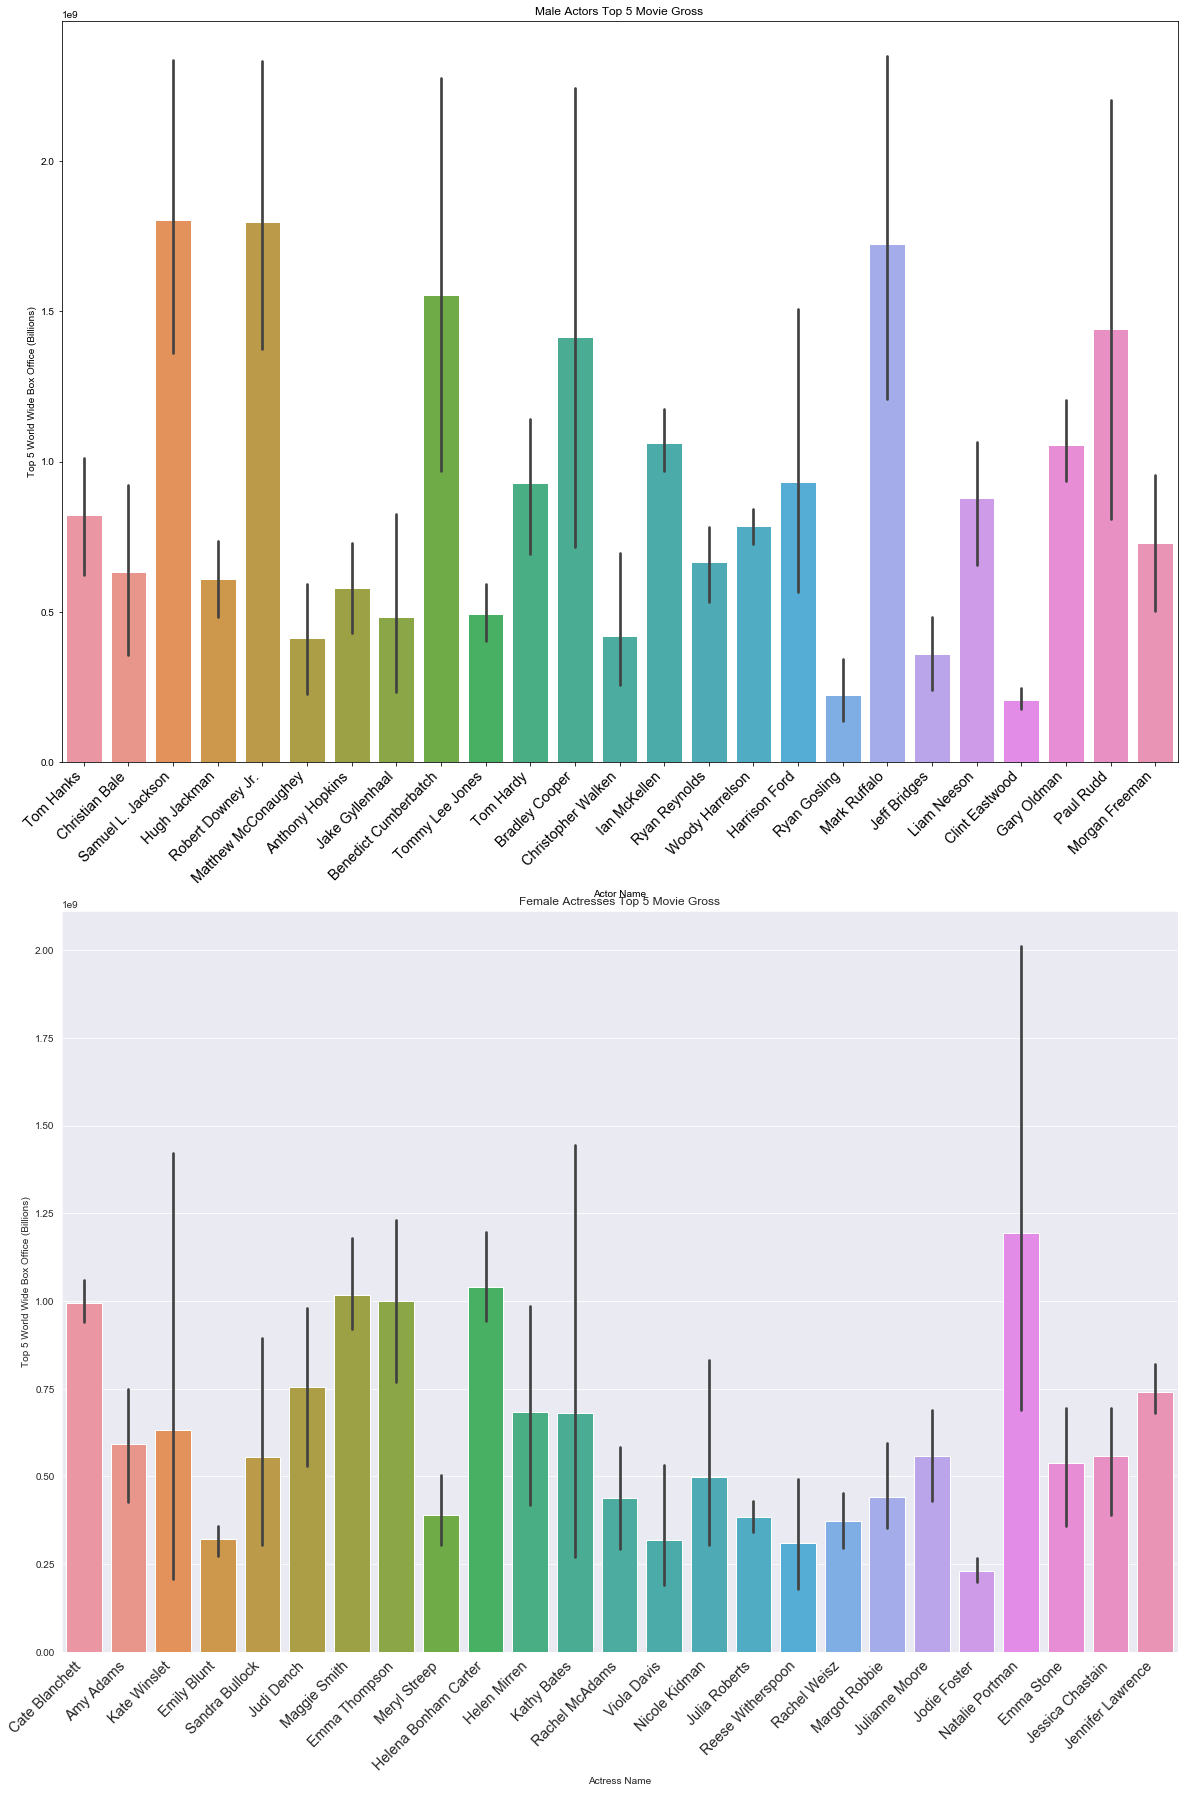

In [10]:
plt.figure(figsize=(20,30))
ax1 = plt.subplot(2, 1, 1)
sns.set_style('darkgrid')
maleplot = sns.barplot(x = actorDf["Name"], y = actorDf["WWBO"])
maleplot.set(xlabel = "Actor Name", ylabel='Top 5 World Wide Box Office (Billions)', title='Male Actors Top 5 Movie Gross')
maleplot.set_xticklabels(maleplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');

ax2 = plt.subplot(2, 1, 2)
sns.set_style('darkgrid')
femaleplot = sns.barplot(x = actressDf["Name"], y = actressDf["WWBO"])
femaleplot.set(xlabel = "Actress Name", ylabel='Top 5 World Wide Box Office (Billions)', title='Female Actresses Top 5 Movie Gross')
femaleplot.set_xticklabels(femaleplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');



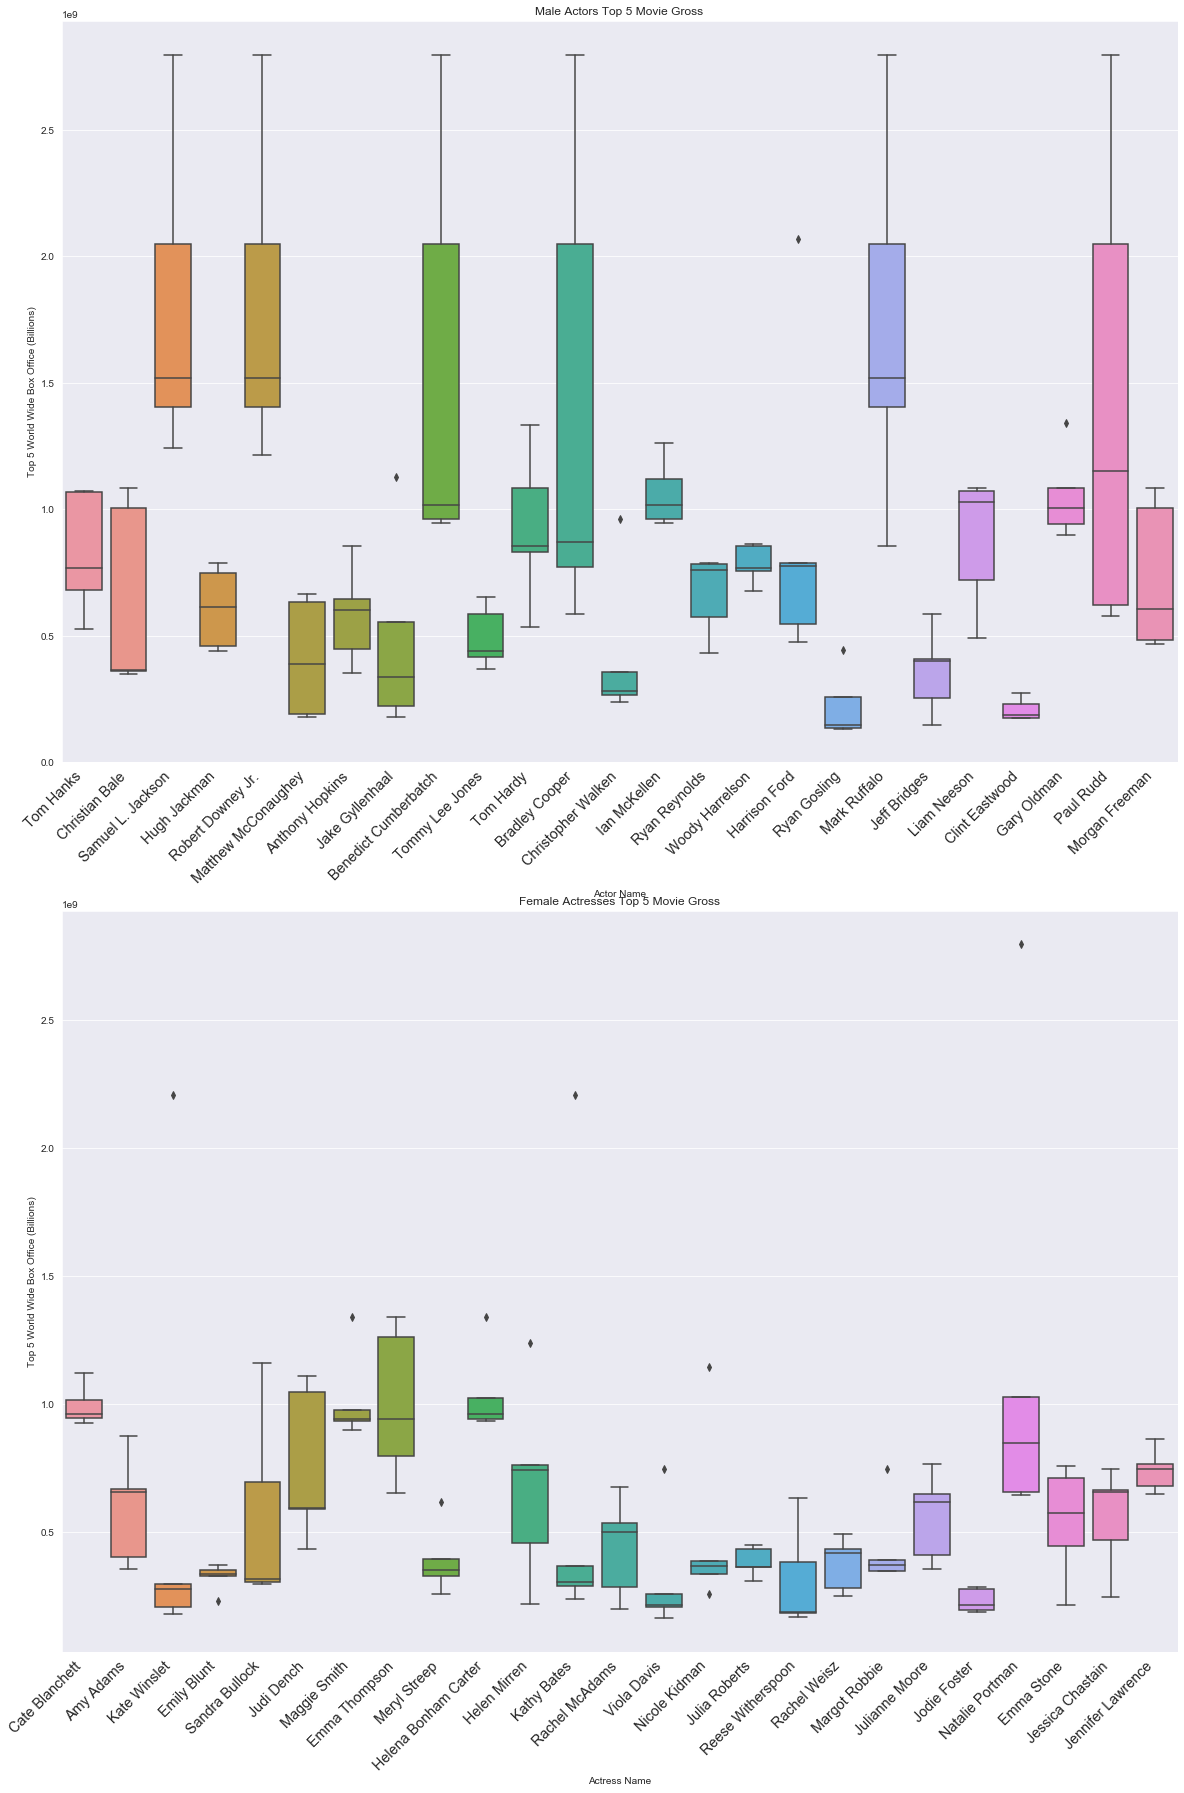

In [33]:
plt.figure(figsize=(20,30))
ax3 = plt.subplot(2, 1, 1)
sns.set_style('darkgrid')
maleplot = sns.boxplot(x = actorDf["Name"], y = actorDf["WWBO"])
maleplot.set(xlabel = "Actor Name", ylabel='Top 5 World Wide Box Office (Billions)', title='Male Actors Top 5 Movie Gross')
maleplot.set_xticklabels(maleplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');

ax4 = plt.subplot(2, 1, 2)
sns.set_style('darkgrid')
femaleplot = sns.boxplot(x = actressDf["Name"], y = actressDf["WWBO"])
femaleplot.set(xlabel = "Actress Name", ylabel='Top 5 World Wide Box Office (Billions)', title='Female Actresses Top 5 Movie Gross')
femaleplot.set_xticklabels(femaleplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');

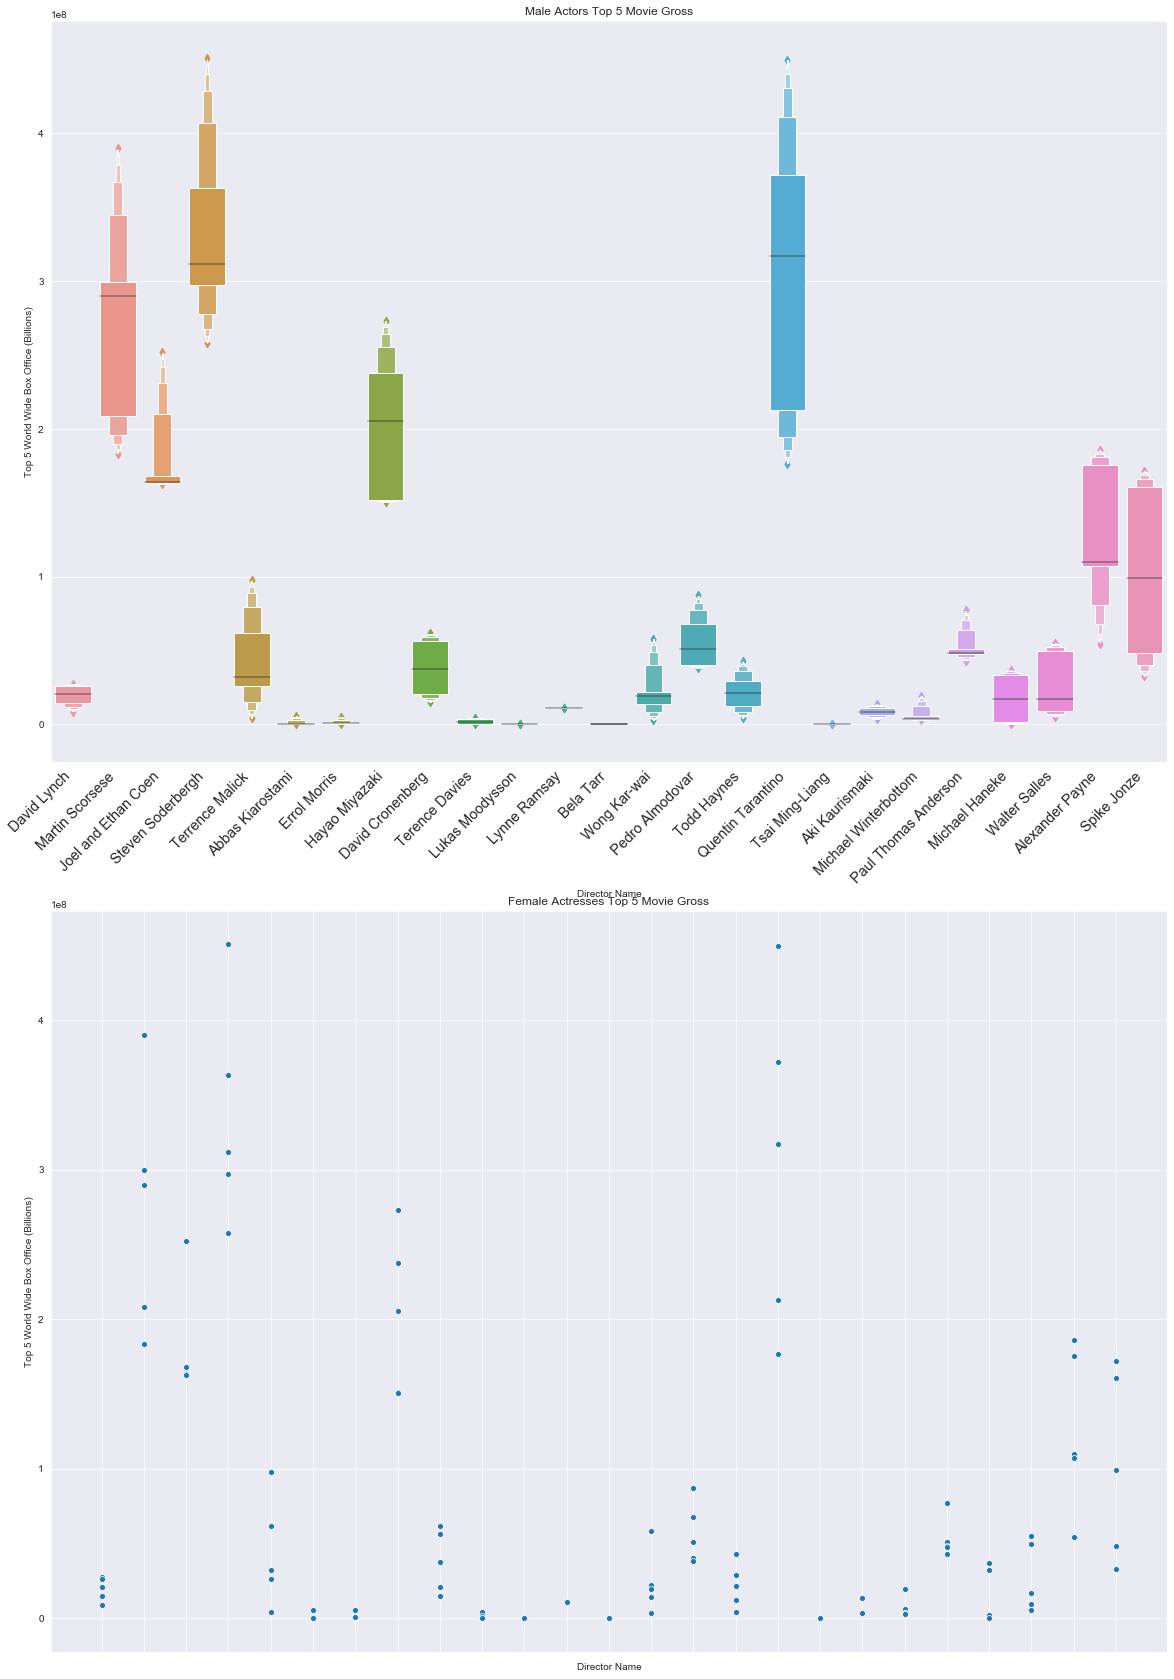

In [12]:
plt.figure(figsize=(20,30))
ax1 = plt.subplot(2, 1, 1)
sns.set_style('darkgrid')
dirplot = sns.boxenplot(x = directorDf["Name"], y = directorDf["WWBO"])
dirplot.set(xlabel = "Director Name", ylabel='Top 5 World Wide Box Office (Billions)', title='Male Actors Top 5 Movie Gross')
dirplot.set_xticklabels(dirplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');

ax2 = plt.subplot(2, 1, 2)
sns.set_style('darkgrid')
dirplot = sns.scatterplot(x = directorDf["Name"], y = directorDf["WWBO"])
dirplot.set(xlabel = "Director Name", ylabel='Top 5 World Wide Box Office (Billions)', title='Female Actresses Top 5 Movie Gross')
dirplot.set_xticklabels(dirplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');


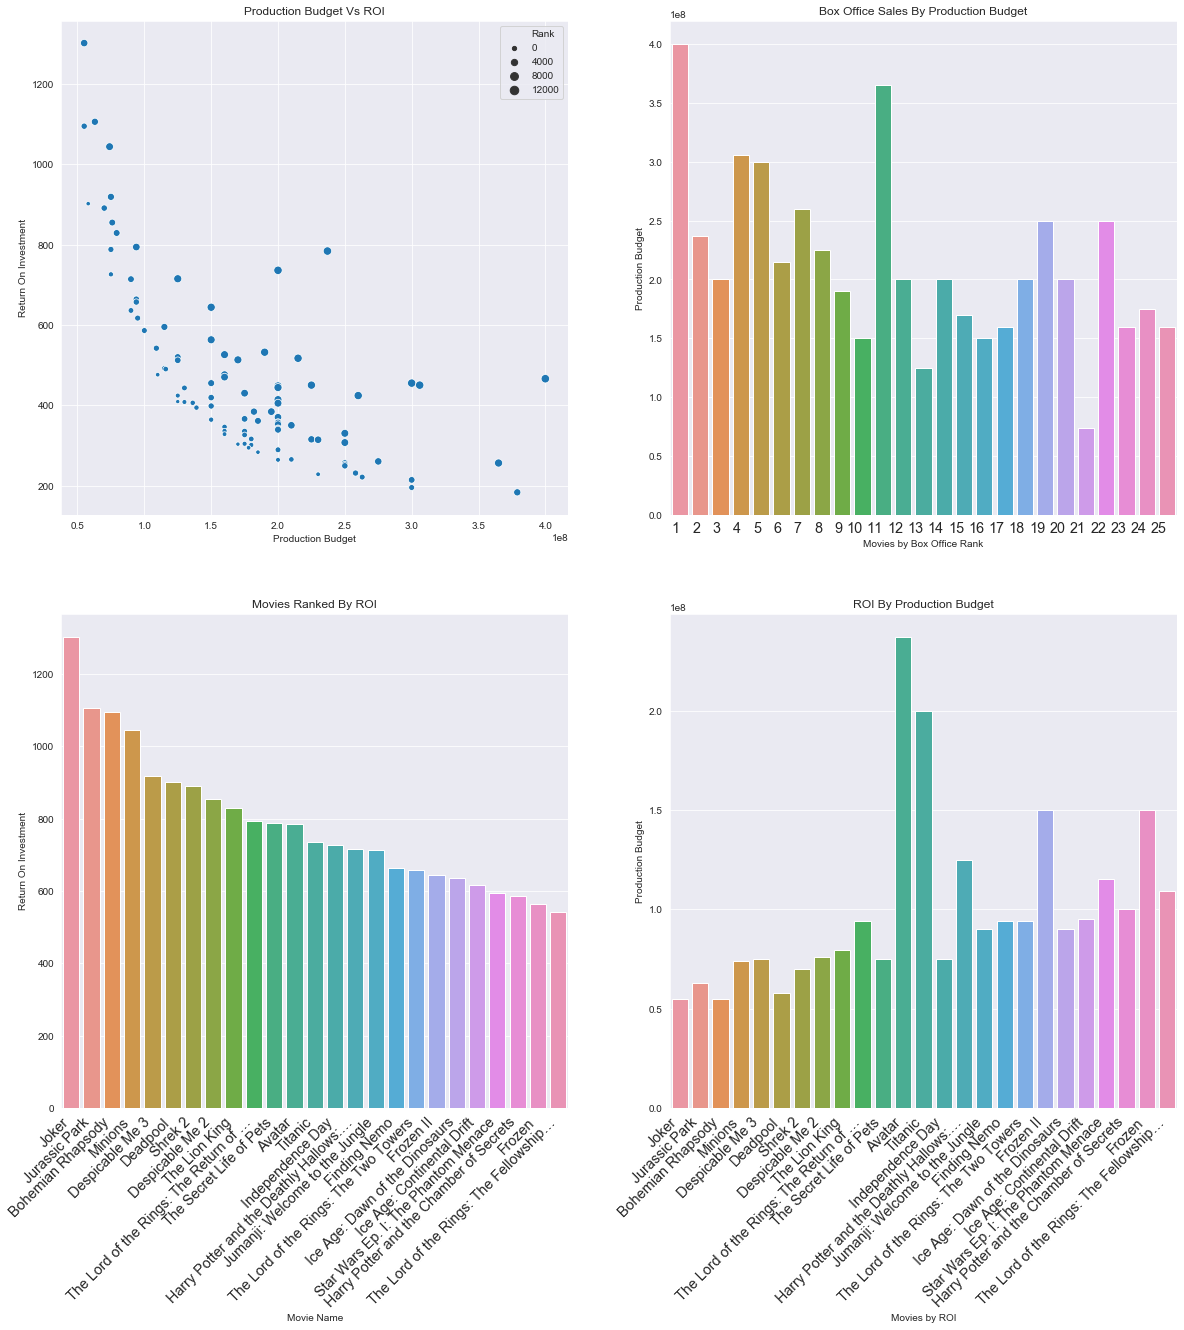

In [46]:
plt.figure(figsize=(20,20))
sns.set_style('darkgrid')


ax1 = plt.subplot(2, 2, 1)
movieplot = sns.scatterplot(
    x = moviesDf["Production Budget"], 
    y = moviesDf["Return On Investment"],
    size = 10000 - 100 * moviesDf['Rank'])
movieplot.set(title = 'Production Budget Vs ROI')

moviesDf = moviesDf.sort_values(by="Rank")
ax2 = plt.subplot(2, 2, 2)
movieplot = sns.barplot(x = moviesDf["Rank"][:25], y = moviesDf["Production Budget"])
movieplot.set(xlabel = "Movies by Box Office Rank", ylabel='Production Budget', title='Box Office Sales By Production Budget')
movieplot.set_xticklabels(movieplot.get_xticklabels(), horizontalalignment='right', fontsize='x-large');

moviesDf = moviesDf.sort_values(by="Return On Investment", ascending=False)
ax3 = plt.subplot(2, 2, 3)
movieplot = sns.barplot(x = moviesDf["Movie Name"][:25], y = moviesDf["Return On Investment"])
movieplot.set(title = 'Movies Ranked By ROI')
movieplot.set_xticklabels(movieplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');

ax4 = plt.subplot(2, 2, 4)
movieplot = sns.barplot(x = moviesDf["Movie Name"][:25], y = moviesDf["Production Budget"])
movieplot.set(xlabel = "Movies by ROI", title='ROI By Production Budget')
movieplot.set_xticklabels(movieplot.get_xticklabels(),rotation=45, horizontalalignment='right', fontsize='x-large');
